In [111]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [112]:
# LOAD ROBOT
robot = loadKinton()
robot.initDisplay(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

In [114]:
# DEFINE TARGET POSITION
target_pos  = np.array([0,0,1])
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

# Plot goal frame
robot.viewer.gui.addXYZaxis('world/framegoal', [1., 0., 0., 1.], .015, 4)
robot.viewer.gui.applyConfiguration('world/framegoal', target_pos.tolist() + [target_quat[0], target_quat[1], target_quat[2], target_quat[3]])
robot.viewer.gui.refresh()

In [115]:
# ACTUATION MODEL
actModel = ActuationModelUAM(robot.model)

# COST MODEL
# Create a cost model per the running and terminal action model.
runningCostModel = CostModelSum(robot.model, actModel.nu)
terminalCostModel = CostModelSum(robot.model, actModel.nu)

frameName = 'base_link'
state = StatePinocchio(robot.model)
SE3ref = pin.SE3()
SE3ref.translation = target_pos.reshape(3,1)
SE3ref.rotation = target_quat.matrix()


stateWeights = np.array([0] * 3 + [500.] * 3 + [0.01] * (robot.model.nv - 2) + [10] * robot.model.nv)
goalTrackingCost = CostModelFramePlacement(robot.model,
                                           frame=robot.model.getFrameId(frameName),
                                           ref=SE3ref,
                                           nu =actModel.nu)
xRegCost = CostModelState(robot.model, state, ref=state.zero(), nu=actModel.nu)
uRegCost = CostModelControl(robot.model, nu=robot.model.nv-2)

# Then let's add the running and terminal cost functions
runningCostModel.addCost(name="pos", weight=0.1, cost=goalTrackingCost)
runningCostModel.addCost(name="regx", weight=1e-5, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-7, cost=uRegCost)
terminalCostModel.addCost(name="pos", weight=50, cost=goalTrackingCost)

# DIFFERENTIAL ACTION MODEL
runningModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, terminalCostModel))

In [116]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

# Defining the time duration for running action models and the terminal one
dt = 1e-3
runningModel.timeStep = dt

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 500
q0 = robot.model.referenceConfigurations["initial_pose"]

x0 = np.hstack([m2a(q0), np.zeros(robot.model.nv)])
problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

# Solving it with the DDP algorithm
ddp.solve()

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  7.26954e+00  1.01735e-05  9.62434e+01  1.00000e-09  1.00000e-09   1.0000     1
   1  2.81986e+00  1.25848e-06  8.92713e+00  1.00000e-09  1.00000e-09   1.0000     1
   2  2.79917e+00  5.40348e-09  4.13316e-02  1.00000e-09  1.00000e-09   1.0000     1
   3  2.79916e+00  4.83151e-12  2.97873e-05  1.00000e-09  1.00000e-09   1.0000     1


([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  array([-1.33325576e-09,  1.56950264e-20,  6.50683190e-04,  1.03040522e-17,
          9.70119766e-07,  2.23585706e-18,  1.00000000e+00,  3.31193242e-17,
          1.48746279e-17,  1.11334492e-05,  4.18934321e-09, -5.00376766e-06,
         -2.71365688e-17, -1.96449638e-06,  2.23997034e-17,  6.50683190e-01,
          2.06081043e-14,  1.94023953e-03,  4.47171412e-15,  3.31193242e-14,
          1.48746279e-14,  1.11334492e-02,  4.18934321e-06, -5.00376766e-03,
         -2.71365688e-14]),
  array([-9.66517403e-10,  1.53133220e-20,  1.92798373e-03,  2.41256192e-17,
          2.13625709e-06,  3.78907141e-18,  1.00000000e+00,  7.90598990e-17,
          4.43456995e-17,  2.64262320e-05,  1.75599819e-06, -1.04041370e-05,
         -6.66115440e-17, -3.60103850e-06,  4.35953429e-17,  1.27730054e+00,
          2.76431363e-14,  2.33227465e-03,  3.10643149e-15,  4.59405749e-14,
     

In [118]:
displayTrajectory(robot, ddp.xs, runningModel.timeStep)

In [119]:
thrust = []
Mr = [];
Mp = [];
My = [];
for u in ddp.us:
    thrust.append(u[0])
    Mr.append(u[1])
    Mp.append(u[2])
    My.append(u[3])

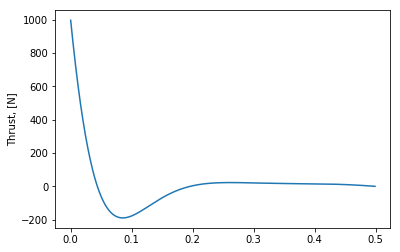

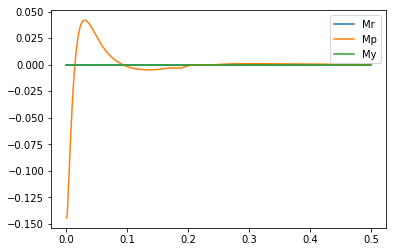

In [120]:
import matplotlib.pyplot as plt
t = np.arange(0., T*dt, dt)

plt.figure()
plt.plot(t, thrust)
plt.ylabel('Thrust, [N]')

plt.figure()
plt.plot(t,Mr, t,Mp, t,My)
plt.legend(['Mr','Mp','My'])

In [92]:
robot.display(q0)